<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/Find_CompProfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [19]:
import csv
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from google.colab import files
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1D Composition Profile Plot

## Extract Data and Name Variables

In [28]:
# Experimental Data (RMC Reconstruction)
file = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Coreshell5050_AuPd_onAu/RMC_Coreshell5050_AuPd_onAu_1-10-10_v1/1-10.stru"
# Reference Data File (MC Target)
file_ref = "https://raw.githubusercontent.com/AndrewCrossman/Graduate_Research/main/Tests/Coreshell5050_AuPd_onAu/MC_Coreshell5050_AuPd_onAu_r25_2000Cycles/2000_voidless.stru"
# Save file names

plotTitle = r'$Au_{50}Pd_{50}$: 1-10-10'
plotsavename_by_atom = 'Au50Pd50_1-10-10_CP_by_atom.png'
csvsavename_by_atom = 'Au50Pd50_1-10-10_1D_CP_by_atom.csv'

plotsavename_by_atom_red = 'Au50Pd50_1-10-10_CP_by_atom_red.png'
csvsavename_by_atom_red = 'Au50Pd50_1-10-10_1D_CP_by_atom_red.csv'

plotsavename_by_rad = 'Au50Pd50_1-10-10_CP_by_rad.png'
csvsavename_by_rad = 'Au50Pd50_1-10-10_1D_CP_by_rad.csv'

plotsavename_by_rad_red = 'Au50Pd50_1-10-10_CP_by_rad_red.png'
csvsavename_by_rad_red = 'Au50Pd50_1-10-10_1D_CP_by_rad_red.csv'
# Reference Atoms
atom = 'AU'         # This atom has its composition profile measured
other_atom = 'PD'   # This atom is used for Labeling Purposes

In [21]:
'''
NOTE: A discus update made it so skiprows=3 or skiprows=4
'''
################################################################################
# Extract Experimental Data (RMC)
################################################################################
data = pd.read_csv(file, skiprows=4)
data = data.drop(data.columns[3:], axis=1)
data[["atoms", "x"]] = data[data.columns[0]].str.split(expand=True)
data = data.drop(data.columns[0], axis=1)
data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data = data[data.atom!='VOID']        # Removes all voids
data["x"] = data["x"].astype(float)
data["y"] = data["y"].astype(float)
data["z"] = data["z"].astype(float)
data["distance"] = np.sqrt((data["x"]*data["x"] + data["y"]*data["y"] + data["z"]*data["z"])*(4.0789*4.0789))
data["reduced_distance"] = data["distance"]*(1/np.percentile(data["distance"], 99)) #assumes less than 1% of atoms have evaporated off surface
# Output relevant structural info
print("Max distance in angstroms "+str(round(data["distance"].max(),5)) +" - RMC Data")
print("Min distance in angstroms "+str(round(data["distance"].min(),5)) +" - RMC Data")
################################################################################
# Extract Reference Data (MMC)
################################################################################
data_ref = pd.read_csv(file_ref, skiprows=4)
data_ref = data_ref.drop(data_ref.columns[3:], axis=1)
data_ref[["atoms", "x"]] = data_ref[data_ref.columns[0]].str.split(expand=True)
data_ref = data_ref.drop(data_ref.columns[0], axis=1)
data_ref = data_ref.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
data_ref = data_ref[data_ref.atom!='VOID']
data_ref["x"] = data_ref["x"].astype(float)
data_ref["y"] = data_ref["y"].astype(float)
data_ref["z"] = data_ref["z"].astype(float)
data_ref["distance"] = np.sqrt((data_ref["x"]*data_ref["x"] + data_ref["y"]*data_ref["y"] + data_ref["z"]*data_ref["z"])*(4.0789*4.0789))
data_ref["reduced_distance"] = data_ref["distance"]*(1/data_ref["distance"].max())
# Output relevant structural info
print("Max distance in angstroms "+str(round(data_ref["distance"].max(),5)) +" - MC Ref")
print("Min distance in angstroms "+str(round(data_ref["distance"].min(),5)) +" - MC Ref")

<ipython-input-21-fd3fcc42e8a8>:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data = data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
<ipython-input-21-fd3fcc42e8a8>:28: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  data_ref = data_ref.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


Max distance in angstroms 27.10757 - RMC Data
Min distance in angstroms 0.20591 - RMC Data
Max distance in angstroms 25.19361 - MC Ref
Min distance in angstroms 0.09619 - MC Ref


In [22]:
len(data.index)

3924

### Bin Data by Atom Count Using Absolute Distance

In [23]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
# For structures with 3925 atoms
################################################################################
# Make bins sizes based off of maximum radius
RMC_Bins = []
MMC_Bins = []
RMC_other_counts = []
RMC_atom_counts = []
MMC_other_counts = []
MMC_atom_counts = []
for i in range(25):
    RMC_temp = data.nsmallest(157*(i+1), "distance")[-157:]
    MMC_temp = data_ref.nsmallest(157*(i+1), "distance")[-157:]

    RMC_Bins.append(RMC_temp["distance"].mean())
    MMC_Bins.append(MMC_temp["distance"].mean())

    RMC_atom_count = len(RMC_temp[RMC_temp["atom"]==atom])
    RMC_other_count = len(RMC_temp[RMC_temp["atom"]!=atom])
    MMC_atom_count = len(MMC_temp[MMC_temp["atom"]==atom])
    MMC_other_count = len(MMC_temp[MMC_temp["atom"]!=atom])

    RMC_atom_counts.append(RMC_atom_count/(len(RMC_temp)))
    RMC_other_counts.append(RMC_other_count/(len(RMC_temp)))
    MMC_atom_counts.append(MMC_atom_count/(len(MMC_temp)))
    MMC_other_counts.append(MMC_other_count/(len(MMC_temp)))

In [6]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
# For structures with 30885 atoms
################################################################################
# Make bins sizes based off of maximum radius
RMC_Bins = []
MMC_Bins = []
RMC_other_counts = []
RMC_atom_counts = []
MMC_other_counts = []
MMC_atom_counts = []
for i in range(71):
    RMC_temp = data.nsmallest(435*(i+1), "distance")[-435:]
    MMC_temp = data_ref.nsmallest(435*(i+1), "distance")[-435:]

    RMC_Bins.append(RMC_temp["distance"].mean())
    MMC_Bins.append(MMC_temp["distance"].mean())

    RMC_atom_count = len(RMC_temp[RMC_temp["atom"]==atom])
    RMC_other_count = len(RMC_temp[RMC_temp["atom"]!=atom])
    MMC_atom_count = len(MMC_temp[MMC_temp["atom"]==atom])
    MMC_other_count = len(MMC_temp[MMC_temp["atom"]!=atom])

    RMC_atom_counts.append(RMC_atom_count/(len(RMC_temp)))
    RMC_other_counts.append(RMC_other_count/(len(RMC_temp)))
    MMC_atom_counts.append(MMC_atom_count/(len(MMC_temp)))
    MMC_other_counts.append(MMC_other_count/(len(MMC_temp)))

### Bin Date by Atom Count Using Reduced Distance

In [24]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
# For structures with 3925 atoms
################################################################################
# Make bins sizes based off of maximum radius
RMC_Bins_red = []
MMC_Bins_red = []
RMC_other_counts_red = []
RMC_atom_counts_red = []
MMC_other_counts_red = []
MMC_atom_counts_red = []
for i in range(25):
    RMC_temp_red = data.nsmallest(157*(i+1), "reduced_distance")[-157:]
    MMC_temp_red = data_ref.nsmallest(157*(i+1), "reduced_distance")[-157:]

    RMC_Bins_red.append(RMC_temp_red["reduced_distance"].mean())
    MMC_Bins_red.append(MMC_temp_red["reduced_distance"].mean())

    RMC_atom_count_red = len(RMC_temp_red[RMC_temp_red["atom"]==atom])
    RMC_other_count_red = len(RMC_temp_red[RMC_temp_red["atom"]!=atom])
    MMC_atom_count_red = len(MMC_temp_red[MMC_temp_red["atom"]==atom])
    MMC_other_count_red = len(MMC_temp_red[MMC_temp_red["atom"]!=atom])

    RMC_atom_counts_red.append(RMC_atom_count_red/(len(RMC_temp_red)))
    RMC_other_counts_red.append(RMC_other_count_red/(len(RMC_temp_red)))
    MMC_atom_counts_red.append(MMC_atom_count_red/(len(MMC_temp_red)))
    MMC_other_counts_red.append(MMC_other_count_red/(len(MMC_temp_red)))

In [8]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
# For structures with 30885 atoms
################################################################################
# Make bins sizes based off of maximum radius
RMC_Bins_red = []
MMC_Bins_red = []
RMC_other_counts_red = []
RMC_atom_counts_red = []
MMC_other_counts_red = []
MMC_atom_counts_red = []
for i in range(71):
    RMC_temp_red = data.nsmallest(435*(i+1), "reduced_distance")[-435:]
    MMC_temp_red = data_ref.nsmallest(435*(i+1), "reduced_distance")[-435:]

    RMC_Bins_red.append(RMC_temp_red["reduced_distance"].mean())
    MMC_Bins_red.append(MMC_temp_red["reduced_distance"].mean())

    RMC_atom_count_red = len(RMC_temp_red[RMC_temp_red["atom"]==atom])
    RMC_other_count_red = len(RMC_temp_red[RMC_temp_red["atom"]!=atom])
    MMC_atom_count_red = len(MMC_temp_red[MMC_temp_red["atom"]==atom])
    MMC_other_count_red = len(MMC_temp_red[MMC_temp_red["atom"]!=atom])

    RMC_atom_counts_red.append(RMC_atom_count_red/(len(RMC_temp_red)))
    RMC_other_counts_red.append(RMC_other_count_red/(len(RMC_temp_red)))
    MMC_atom_counts_red.append(MMC_atom_count_red/(len(MMC_temp_red)))
    MMC_other_counts_red.append(MMC_other_count_red/(len(MMC_temp_red)))

### Bin Data by Radial Distance

In [25]:
################################################################################
# Bin Data between 0 and custom radial distance in "numbin" divisions
################################################################################
# Make bins sizes based off of custom max radius
numbin = 13
#numbin = 25

realBins_custom = np.around(np.linspace(0,26.15,numbin),decimals=2)
#realBins_custom = np.around(np.linspace(0,50.45,numbin),decimals=2)

data["bin_custom"] = pd.cut(data["distance"], bins=realBins_custom, right=False, precision=2,include_lowest='True',labels=realBins_custom[1:])
data["bin_customn"] = data["bin_custom"].astype(float)
data_ref["bin_custom"] = pd.cut(data_ref["distance"], bins=realBins_custom, right=False, precision=2,include_lowest='True',labels=realBins_custom[1:])
data_ref["bin_custom"] = data_ref["bin_custom"].astype(float)
data = data[["atom","x","y","z","distance","bin_custom"]]
data_ref = data_ref[["atom","x","y","z","distance","bin_custom"]]
################################################################################
# Group atom type by bin in order to plot
################################################################################
data_grouped_custom = (data.groupby("bin_custom")["atom"].value_counts(normalize=True).unstack()).fillna(0)
data_ref_grouped_custom = (data_ref.groupby("bin_custom")["atom"].value_counts(normalize=True).unstack()).fillna(0)
################################################################################
# Output atom/bin grouping info to reference
################################################################################
print("RMC DATA")
print("BIN     #Atoms")
print(data.bin_custom.value_counts())
print("MC DATA")
print("BIN     #Atoms")
print(data_ref.bin_custom.value_counts())


RMC DATA
BIN     #Atoms
23.97    915
21.79    666
19.61    591
26.15    468
17.43    390
15.25    345
13.08    226
10.9     168
8.72      81
6.54      53
4.36      18
2.18       1
Name: bin_custom, dtype: int64
MC DATA
BIN     #Atoms
23.97    916
21.79    665
19.61    580
26.15    490
17.43    398
15.25    323
13.08    231
10.90    163
8.72      86
6.54      53
4.36      18
2.18       1
Name: bin_custom, dtype: int64


### Bin Data by Reduced Radial Distance

In [26]:
################################################################################
# Bin Data between 0 and max distance in "numbin" divisions
################################################################################
# Make bins sizes based off of custom max radius
numbin = 13

data["reduced_distance"] = data["distance"]*(1/np.percentile(data["distance"], 99)) #assumes less than 1% of atoms have evaporated off surface
data_ref["reduced_distance"] = data_ref["distance"]*(1/data_ref["distance"].max())

realBins_reduced = np.around(np.linspace(0,1,numbin),decimals=2)

data["bin_reduced"] = pd.cut(data["reduced_distance"], bins=realBins_reduced, right=False, precision=2,include_lowest='True',labels=realBins_reduced[1:])
data["bin_reduced"] = data["bin_reduced"].astype(float)
data_ref["bin_reduced"] = pd.cut(data_ref["reduced_distance"], bins=realBins_reduced, right=False, precision=2,include_lowest='True',labels=realBins_reduced[1:])
data_ref["bin_reduced"] = data_ref["bin_reduced"].astype(float)
data = data[["atom","x","y","z","distance","bin_custom","bin_reduced"]]
data_ref = data_ref[["atom","x","y","z","distance","bin_custom","bin_reduced"]]
################################################################################
# Group atom type by bin in order to plot
################################################################################
data_grouped_reduced = (data.groupby("bin_reduced")["atom"].value_counts(normalize=True).unstack()).fillna(0)
data_ref_grouped_reduced = (data_ref.groupby("bin_reduced")["atom"].value_counts(normalize=True).unstack()).fillna(0)
################################################################################
# Output atom/bin grouping info to reference
################################################################################
print("RMC DATA")
print("BIN     #Atoms")
print(data.bin_reduced.value_counts())
print("MC DATA")
print("BIN     #Atoms")
print(data_ref.bin_reduced.value_counts())

RMC DATA
BIN     #Atoms
0.92    840
1.00    829
0.83    612
0.75    445
0.67    445
0.58    258
0.50    167
0.42    150
0.33     83
0.25     37
0.17     17
0.08      1
Name: bin_reduced, dtype: int64
MC DATA
BIN     #Atoms
0.92    862
1.00    849
0.83    619
0.67    425
0.75    424
0.58    262
0.50    174
0.42    168
0.33     85
0.25     36
0.17     18
0.08      1
Name: bin_reduced, dtype: int64


## Make Composition Profile Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

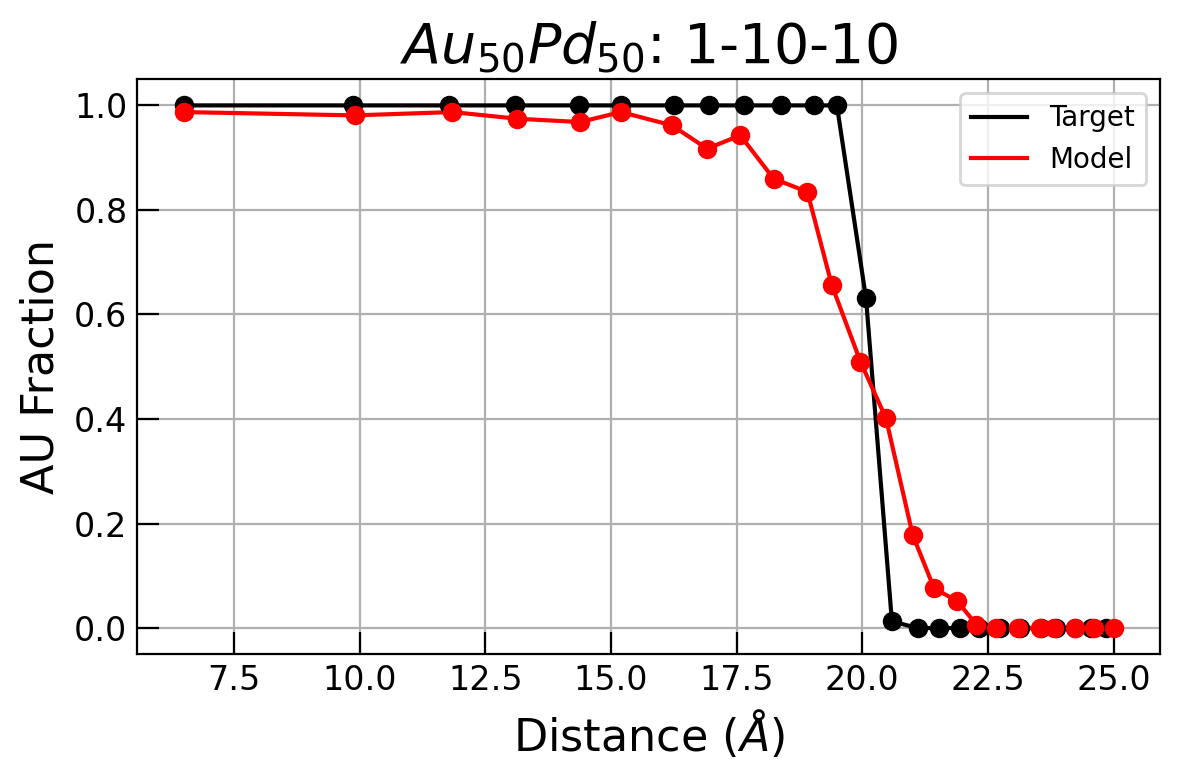

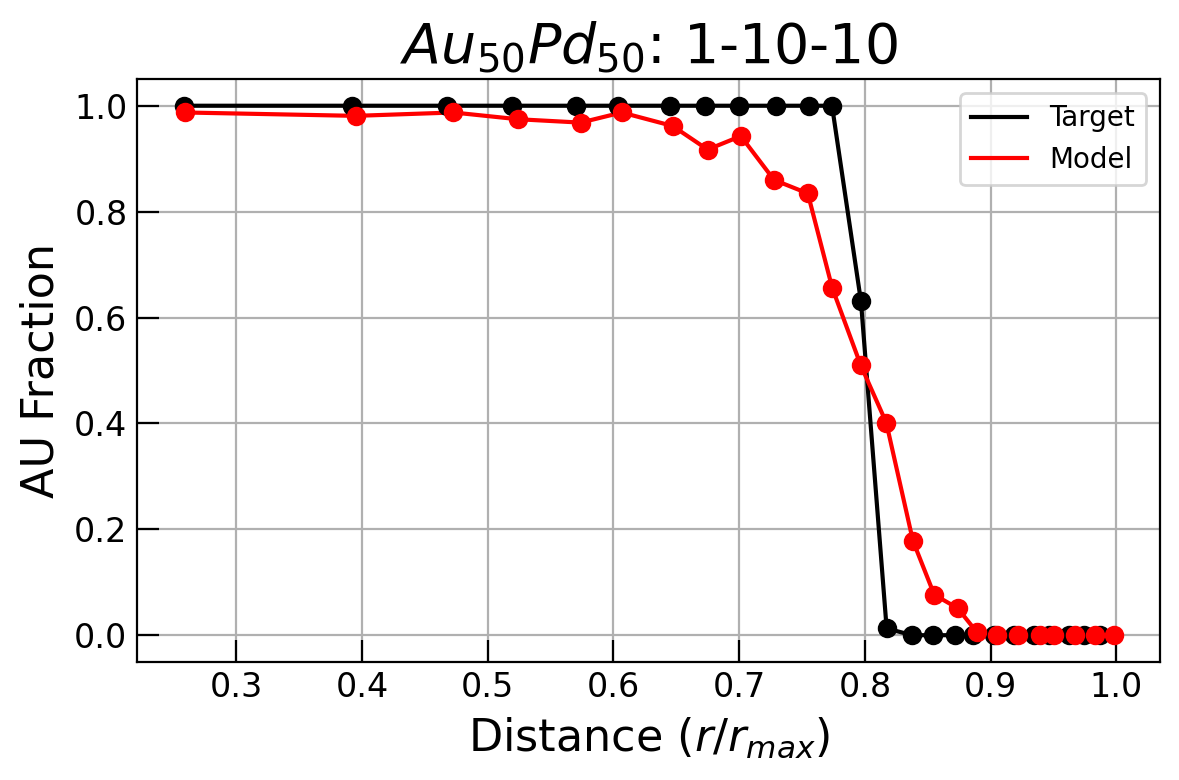

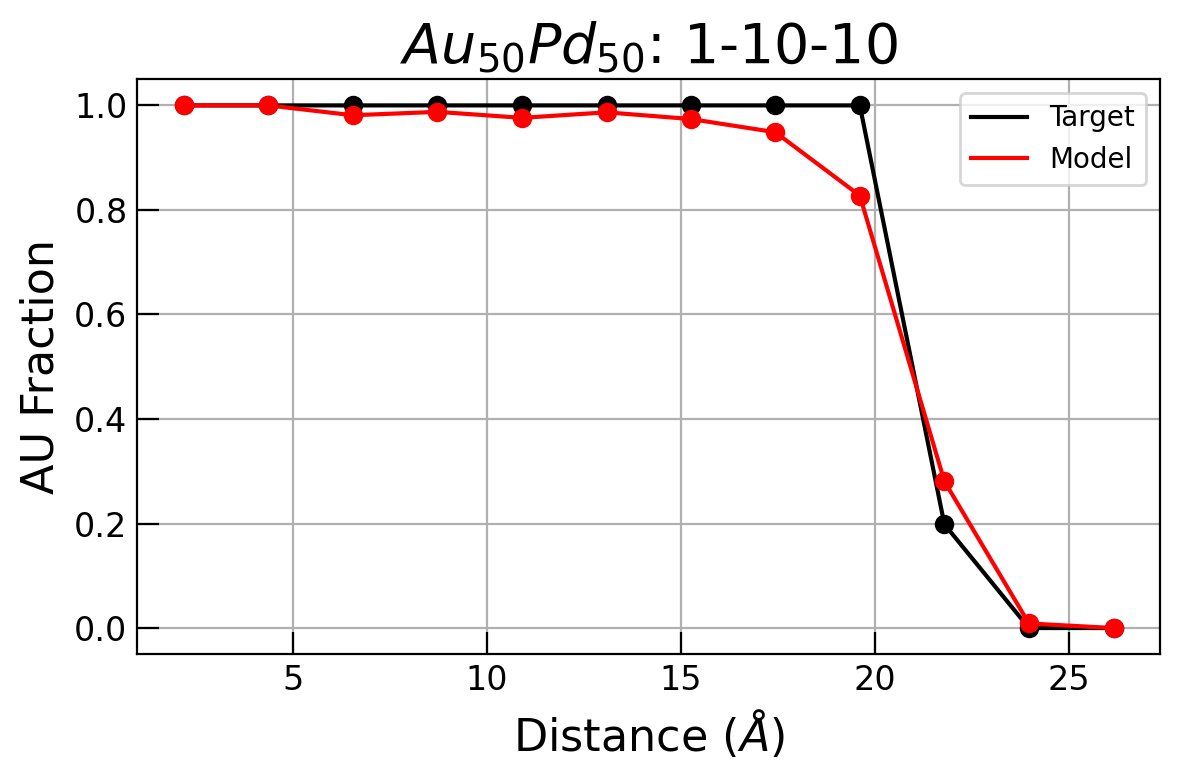

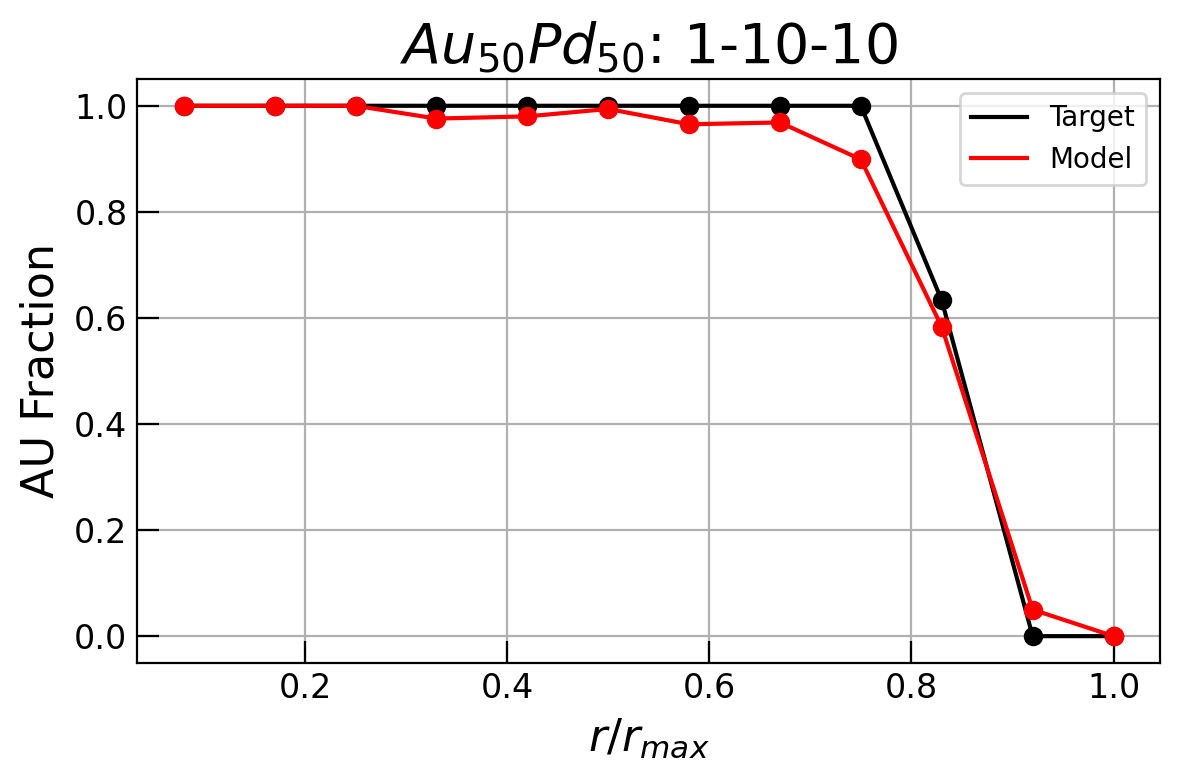

In [29]:
################################################################################
# Plot Data by Atom in Absolute Distance
################################################################################
fig1, ax1 = plt.subplots(figsize=(6,4,),dpi=200)
ax1.plot(MMC_Bins,MMC_atom_counts, color='black', label = "Target", zorder=1)
ax1.plot(RMC_Bins,RMC_atom_counts, color='red', label = "Model", zorder=1)
ax1.scatter(MMC_Bins,MMC_atom_counts, color='black', zorder=2)
ax1.scatter(RMC_Bins,RMC_atom_counts, color='red', zorder=2)
# Plot settings
ax1.set_title(plotTitle, fontsize=20)
ax1.set_ylabel(atom+" Fraction", fontsize=16)
ax1.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax1.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax1.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax1.legend()
ax1.grid(True)
ax1.set_axisbelow(True)
plt.tight_layout()
fig1.savefig(plotsavename_by_atom)
files.download(plotsavename_by_atom)
################################################################################
# Plot Data by Atom in Reduced Distance
################################################################################
fig11, ax11 = plt.subplots(figsize=(6,4,),dpi=200)
ax11.plot(MMC_Bins_red,MMC_atom_counts_red, color='black', label = "Target", zorder=1)
ax11.plot(RMC_Bins_red,RMC_atom_counts_red, color='red', label = "Model", zorder=1)
ax11.scatter(MMC_Bins_red,MMC_atom_counts_red, color='black', zorder=2)
ax11.scatter(RMC_Bins_red,RMC_atom_counts_red, color='red', zorder=2)
# Plot settings
ax11.set_title(plotTitle, fontsize=20)
ax11.set_ylabel(atom+" Fraction", fontsize=16)
ax11.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax11.set_xlabel(r'Distance $(r/r_{max})$', fontsize=16)
ax11.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax11.legend()
ax11.grid(True)
ax11.set_axisbelow(True)
plt.tight_layout()
fig11.savefig(plotsavename_by_atom_red)
files.download(plotsavename_by_atom_red)
################################################################################
# Plot Data by Custom Radial Bins in Absolute Distance
################################################################################
fig2, ax2 = plt.subplots(figsize=(6,4,),dpi=200)
ax2.plot(realBins_custom[1:len(data_ref_grouped_custom[atom])+1],data_ref_grouped_custom[atom], color='black', label = "Target", zorder=1)
ax2.plot(realBins_custom[1:len(data_grouped_custom[atom])+1],data_grouped_custom[atom], color='red', label = "Model", zorder=1)
ax2.scatter(realBins_custom[1:len(data_ref_grouped_custom[atom])+1],data_ref_grouped_custom[atom], color='black', zorder=2)
ax2.scatter(realBins_custom[1:len(data_grouped_custom[atom])+1],data_grouped_custom[atom], color='red', zorder=2)
# Plot settings
ax2.set_title(plotTitle, fontsize=20)
ax2.set_ylabel(atom+" Fraction", fontsize=16)
ax2.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax2.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax2.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax2.legend()
ax2.grid(True)
ax2.set_axisbelow(True)
plt.tight_layout()
# Uncomment to save and download plots
fig2.savefig(plotsavename_by_rad)
files.download(plotsavename_by_rad)
################################################################################
# Plot Data by Custom Radial Bins in Reduced Distance
################################################################################
fig3, ax3 = plt.subplots(figsize=(6,4,),dpi=200)
ax3.plot(realBins_reduced[1:len(data_ref_grouped_reduced[atom])+1],data_ref_grouped_reduced[atom], color='black', label = "Target", zorder=1)
ax3.plot(realBins_reduced[1:len(data_grouped_reduced[atom])+1],data_grouped_reduced[atom], color='red', label = "Model", zorder=1)
ax3.scatter(realBins_reduced[1:len(data_ref_grouped_reduced[atom])+1],data_ref_grouped_reduced[atom], color='black', zorder=2)
ax3.scatter(realBins_reduced[1:len(data_grouped_reduced[atom])+1],data_grouped_reduced[atom], color='red', zorder=2)
# Plot settings
ax3.set_title(plotTitle, fontsize=20)
ax3.set_ylabel(atom+" Fraction", fontsize=16)
ax3.tick_params(axis='y', labelsize=12, direction='in', length=8)
ax3.set_xlabel(r'$r/r_{max}$', fontsize=16)
ax3.tick_params(axis='x', labelsize=12, direction='in', length=8)
ax3.legend()
ax3.grid(True)
ax3.set_axisbelow(True)
plt.tight_layout()
# Uncomment to save and download plots
fig3.savefig(plotsavename_by_rad_red)
files.download(plotsavename_by_rad_red)

## Output Data as a csv file

In [30]:
# Format output for Atom Count in Absolute Radial Distance
# 4 new variables used for naming csv export file coulmn headers
csv_MMC_atom_counts = 'MMC_'+ atom +'_counts'
csv_MMC_other_atom_counts = 'MMC_'+ other_atom +'_counts'
csv_RMC_atom_counts = 'RMC_'+ atom +'_counts'
csv_RMC_other_atom_counts = 'RMC_'+ other_atom +'_counts'

column_values = ['RMC_Bins', csv_RMC_atom_counts, csv_RMC_other_atom_counts, 'MMC_Bins', csv_MMC_atom_counts, csv_MMC_other_atom_counts]
by_atom = pd.DataFrame(data = np.transpose([RMC_Bins, RMC_atom_counts, RMC_other_counts, MMC_Bins, MMC_atom_counts, MMC_other_counts]), columns = column_values)
by_atom

,RMC_Bins,RMC_AU_counts,RMC_PD_counts,MMC_Bins,MMC_AU_counts,MMC_PD_counts
0,6.495491,0.987261,0.012739,6.505308,1.000000,0.000000
1,9.898807,0.980892,0.019108,9.871574,1.000000,0.000000
2,11.842557,0.987261,0.012739,11.775342,1.000000,0.000000
3,13.131054,0.974522,0.025478,13.080285,1.000000,0.000000
4,14.381311,0.968153,0.031847,14.363521,1.000000,0.000000
5,15.199207,0.987261,0.012739,15.205283,1.000000,0.000000
6,16.213067,0.961783,0.038217,16.243509,1.000000,0.000000
7,16.910532,0.917197,0.082803,16.952717,1.000000,0.000000
8,17.572004,0.942675,0.057325,17.636827,1.000000,0.000000
9,18.234928,0.859873,0.140127,18.379234,1.000000,0.000000


In [31]:
# Format output for Atom Count in Reduced Radial Distance
### CHECK THAT THIS WORKS!!! ###
# 4 new variables used for naming csv export file coulmn headers
csv_MMC_atom_counts_red = 'MMC_'+ atom +'_counts'
csv_MMC_other_atom_counts_red = 'MMC_'+ other_atom +'_counts'
csv_RMC_atom_counts_red = 'RMC_'+ atom +'_counts'
csv_RMC_other_atom_counts_red = 'RMC_'+ other_atom +'_counts'

column_values_red = ['RMC_Bins_red', csv_RMC_atom_counts_red, csv_RMC_other_atom_counts_red, 'MMC_Bins_red', csv_MMC_atom_counts_red, csv_MMC_other_atom_counts_red]
by_atom_red = pd.DataFrame(data = np.transpose([RMC_Bins_red, RMC_atom_counts_red, RMC_other_counts_red, MMC_Bins_red, MMC_atom_counts_red, MMC_other_counts_red]), columns = column_values)
by_atom_red

,RMC_Bins,RMC_AU_counts,RMC_PD_counts,MMC_Bins,MMC_AU_counts,MMC_PD_counts
0,0.259215,0.987261,0.012739,0.258213,1.000000,0.000000
1,0.395032,0.980892,0.019108,0.391828,1.000000,0.000000
2,0.472601,0.987261,0.012739,0.467394,1.000000,0.000000
3,0.524021,0.974522,0.025478,0.519191,1.000000,0.000000
4,0.573915,0.968153,0.031847,0.570125,1.000000,0.000000
5,0.606555,0.987261,0.012739,0.603537,1.000000,0.000000
6,0.647015,0.961783,0.038217,0.644747,1.000000,0.000000
7,0.674848,0.917197,0.082803,0.672897,1.000000,0.000000
8,0.701246,0.942675,0.057325,0.700051,1.000000,0.000000
9,0.727701,0.859873,0.140127,0.729520,1.000000,0.000000


In [32]:
data_ref_grouped_reduced

atom,AU,PD
bin_reduced,,
0.08,1.000000,0.000000
0.17,1.000000,0.000000
0.25,1.000000,0.000000
0.33,1.000000,0.000000
0.42,1.000000,0.000000
0.50,1.000000,0.000000
0.58,1.000000,0.000000
0.67,1.000000,0.000000
0.75,1.000000,0.000000


In [34]:
data_ref_grouped_custom

atom,AU,PD
bin_custom,,
2.18,1.000000,0.000000
4.36,1.000000,0.000000
6.54,1.000000,0.000000
8.72,1.000000,0.000000
10.90,1.000000,0.000000
13.08,1.000000,0.000000
15.25,1.000000,0.000000
17.43,1.000000,0.000000
19.61,1.000000,0.000000


In [33]:
by_atom.to_csv(csvsavename_by_atom)
by_atom_red.to_csv(csvsavename_by_atom_red)
data_grouped_custom.to_csv(csvsavename_by_rad)
data_grouped_reduced.to_csv(csvsavename_by_rad_red)
files.download(csvsavename_by_atom)
files.download(csvsavename_by_atom_red)
files.download(csvsavename_by_rad)
files.download(csvsavename_by_rad_red)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2D Composition Profile Plot

## Extract and Format Data

In [ ]:
# 3D bin space
numbin = 25
numbin = 50

In [ ]:
################################################################################
# Extract RMC Data
################################################################################
RMC_data = pd.read_csv(file, skiprows=4)
RMC_data = RMC_data.drop(RMC_data.columns[3:], axis=1)
RMC_data[["atoms", "x"]] = RMC_data[RMC_data.columns[0]].str.split(expand=True)
RMC_data = RMC_data.drop(RMC_data.columns[0], axis=1)
RMC_data = RMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
RMC_data = RMC_data[RMC_data.atom!='VOID']
################################################################################
# Format RMC Data
################################################################################
RMC_data["x"] = RMC_data["x"].astype(float)
RMC_data["y"] = RMC_data["y"].astype(float)
RMC_data["z"] = RMC_data["z"].astype(float)
RMC_data["distance"] = np.sqrt((RMC_data["x"]*RMC_data["x"] + RMC_data["y"]*RMC_data["y"] + RMC_data["z"]*RMC_data["z"]))
# Output relevant structural info
print("Max distance in angstroms "+str(round(RMC_data["distance"].max(),5)) +" - RMC Data")
print("Min distance in angstroms "+str(round(RMC_data["distance"].min(),5)) +" - RMC Data")
################################################################################
# Extract MMC Data
################################################################################
MMC_data = pd.read_csv(file_ref, skiprows=4)
MMC_data = MMC_data.drop(MMC_data.columns[3:], axis=1)
MMC_data[["atoms", "x"]] = MMC_data[MMC_data.columns[0]].str.split(expand=True)
MMC_data = MMC_data.drop(MMC_data.columns[0], axis=1)
MMC_data = MMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)
MMC_data = MMC_data[MMC_data.atom!='VOID']
################################################################################
# Format MMC Data
################################################################################
MMC_data["x"] = MMC_data["x"].astype(float)
MMC_data["y"] = MMC_data["y"].astype(float)
MMC_data["z"] = MMC_data["z"].astype(float)
MMC_data["distance"] = np.sqrt((MMC_data["x"]*MMC_data["x"] + MMC_data["y"]*MMC_data["y"] + MMC_data["z"]*MMC_data["z"]))
# Output relevant structural info
print("Max distance in angstroms "+str(round(MMC_data["distance"].max(),5)) +" - MMC Data")
print("Min distance in angstroms "+str(round(MMC_data["distance"].min(),5)) +" - MMC Data")

<ipython-input-47-b4f0d64004e7>:8: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  RMC_data = RMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


Max distance in angstroms 13.30158 - RMC Data
Min distance in angstroms 0.12492 - RMC Data
Max distance in angstroms 12.27093 - MMC Data
Min distance in angstroms 0.03234 - MMC Data


<ipython-input-47-b4f0d64004e7>:27: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  MMC_data = MMC_data.set_axis(["y", "z", "atom", "x"], axis=1, inplace=False)


In [ ]:
###############################################################################
# Bin Data
###############################################################################
realBins=[]
if RMC_data["distance"].max() > MMC_data["distance"].max():
  realBins = np.linspace(-1*RMC_data["distance"].max()-.01,RMC_data["distance"].max()+.01,numbin)
else:
  realBins = np.linspace(-1*MMC_data["distance"].max()-.01,MMC_data["distance"].max()+.01,numbin)

RMC_data["xbin"] = pd.cut(RMC_data["x"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["xbin"] = RMC_data["xbin"].astype(float);
RMC_data["ybin"] = pd.cut(RMC_data["y"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["ybin"] = RMC_data["ybin"].astype(float);
RMC_data["zbin"] = pd.cut(RMC_data["z"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
RMC_data["zbin"] = RMC_data["zbin"].astype(float);
RMC_data = RMC_data[["atom","x","y","z","distance","xbin","ybin","zbin"]]

MMC_data["xbin"] = pd.cut(MMC_data["x"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["xbin"] = MMC_data["xbin"].astype(float);
MMC_data["ybin"] = pd.cut(MMC_data["y"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["ybin"] = MMC_data["ybin"].astype(float);
MMC_data["zbin"] = pd.cut(MMC_data["z"], bins=realBins, right=False, include_lowest='True',labels=realBins[1:]);
MMC_data["zbin"] = MMC_data["zbin"].astype(float);
MMC_data = MMC_data[["atom","x","y","z","distance","xbin","ybin","zbin"]]

## Separate Data into 4 dataframes that contain the following information: MMC Atom1, MMC Atom2, RMC Atom1, RMC Atom2

In [ ]:
RMC_data_atom = RMC_data[RMC_data["atom"] == atom]
RMC_data_other = RMC_data[RMC_data["atom"] != atom]
MMC_data_atom = MMC_data[MMC_data["atom"] == atom]
MMC_data_other = MMC_data[MMC_data["atom"] != atom]

### Convert Binned Data into 2D arrays (No slice through sphere)

In [ ]:
MMC_atom_xy = np.zeros((numbin,numbin))
MMC_other_xy = np.zeros((numbin,numbin))
RMC_atom_xy = np.zeros((numbin,numbin))
RMC_other_xy = np.zeros((numbin,numbin))
MMC_atom_yz = np.zeros((numbin,numbin))
MMC_other_yz = np.zeros((numbin,numbin))
RMC_atom_yz = np.zeros((numbin,numbin))
RMC_other_yz = np.zeros((numbin,numbin))
MMC_atom_zx = np.zeros((numbin,numbin))
MMC_other_zx = np.zeros((numbin,numbin))
RMC_atom_zx = np.zeros((numbin,numbin))
RMC_other_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_atom_xy[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["xbin"]==i) & (MMC_data_atom["ybin"]==j)])
      MMC_other_xy[x][y] = len(MMC_data_other.loc[(MMC_data_other["xbin"]==i) & (MMC_data_other["ybin"]==j)])
      RMC_atom_xy[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["xbin"]==i) & (RMC_data_atom["ybin"]==j)])
      RMC_other_xy[x][y] = len(RMC_data_other.loc[(RMC_data_other["xbin"]==i) & (RMC_data_other["ybin"]==j)])

      MMC_atom_yz[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["ybin"]==i) & (MMC_data_atom["zbin"]==j)])
      MMC_other_yz[x][y] = len(MMC_data_other.loc[(MMC_data_other["ybin"]==i) & (MMC_data_other["zbin"]==j)])
      RMC_atom_yz[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["ybin"]==i) & (RMC_data_atom["zbin"]==j)])
      RMC_other_yz[x][y] = len(RMC_data_other.loc[(RMC_data_other["ybin"]==i) & (RMC_data_other["zbin"]==j)])

      MMC_atom_zx[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["zbin"]==i) & (MMC_data_atom["xbin"]==j)])
      MMC_other_zx[x][y] = len(MMC_data_other.loc[(MMC_data_other["zbin"]==i) & (MMC_data_other["xbin"]==j)])
      RMC_atom_zx[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["zbin"]==i) & (RMC_data_atom["xbin"]==j)])
      RMC_other_zx[x][y] = len(RMC_data_other.loc[(RMC_data_other["zbin"]==i) & (RMC_data_other["xbin"]==j)])
    except:
      None
    y+=1
  x+=1

In [ ]:
diff_atom_xy = np.absolute(np.array(MMC_atom_xy) - np.array(RMC_atom_xy))
diff_atom_yz = np.absolute(np.array(MMC_atom_yz) - np.array(RMC_atom_yz))
diff_atom_zx = np.absolute(np.array(MMC_atom_zx) - np.array(RMC_atom_zx))

diff_other_xy = np.absolute(np.array(MMC_other_xy) - np.array(RMC_other_xy))
diff_other_yz = np.absolute(np.array(MMC_other_yz) - np.array(RMC_other_yz))
diff_other_zx = np.absolute(np.array(MMC_other_zx) - np.array(RMC_other_zx))

In [ ]:
vmin = 0
vmax = np.array([MMC_atom_xy.max(), MMC_other_xy.max(), RMC_atom_xy.max(), RMC_other_xy.max(), MMC_atom_yz.max(), MMC_other_yz.max(),
                 RMC_atom_yz.max(), RMC_other_yz.max(), MMC_atom_zx.max(), MMC_other_zx.max(), RMC_atom_zx.max(), RMC_other_zx.max()]).max()
print(vmax)

49.0


### Plot Binned Data

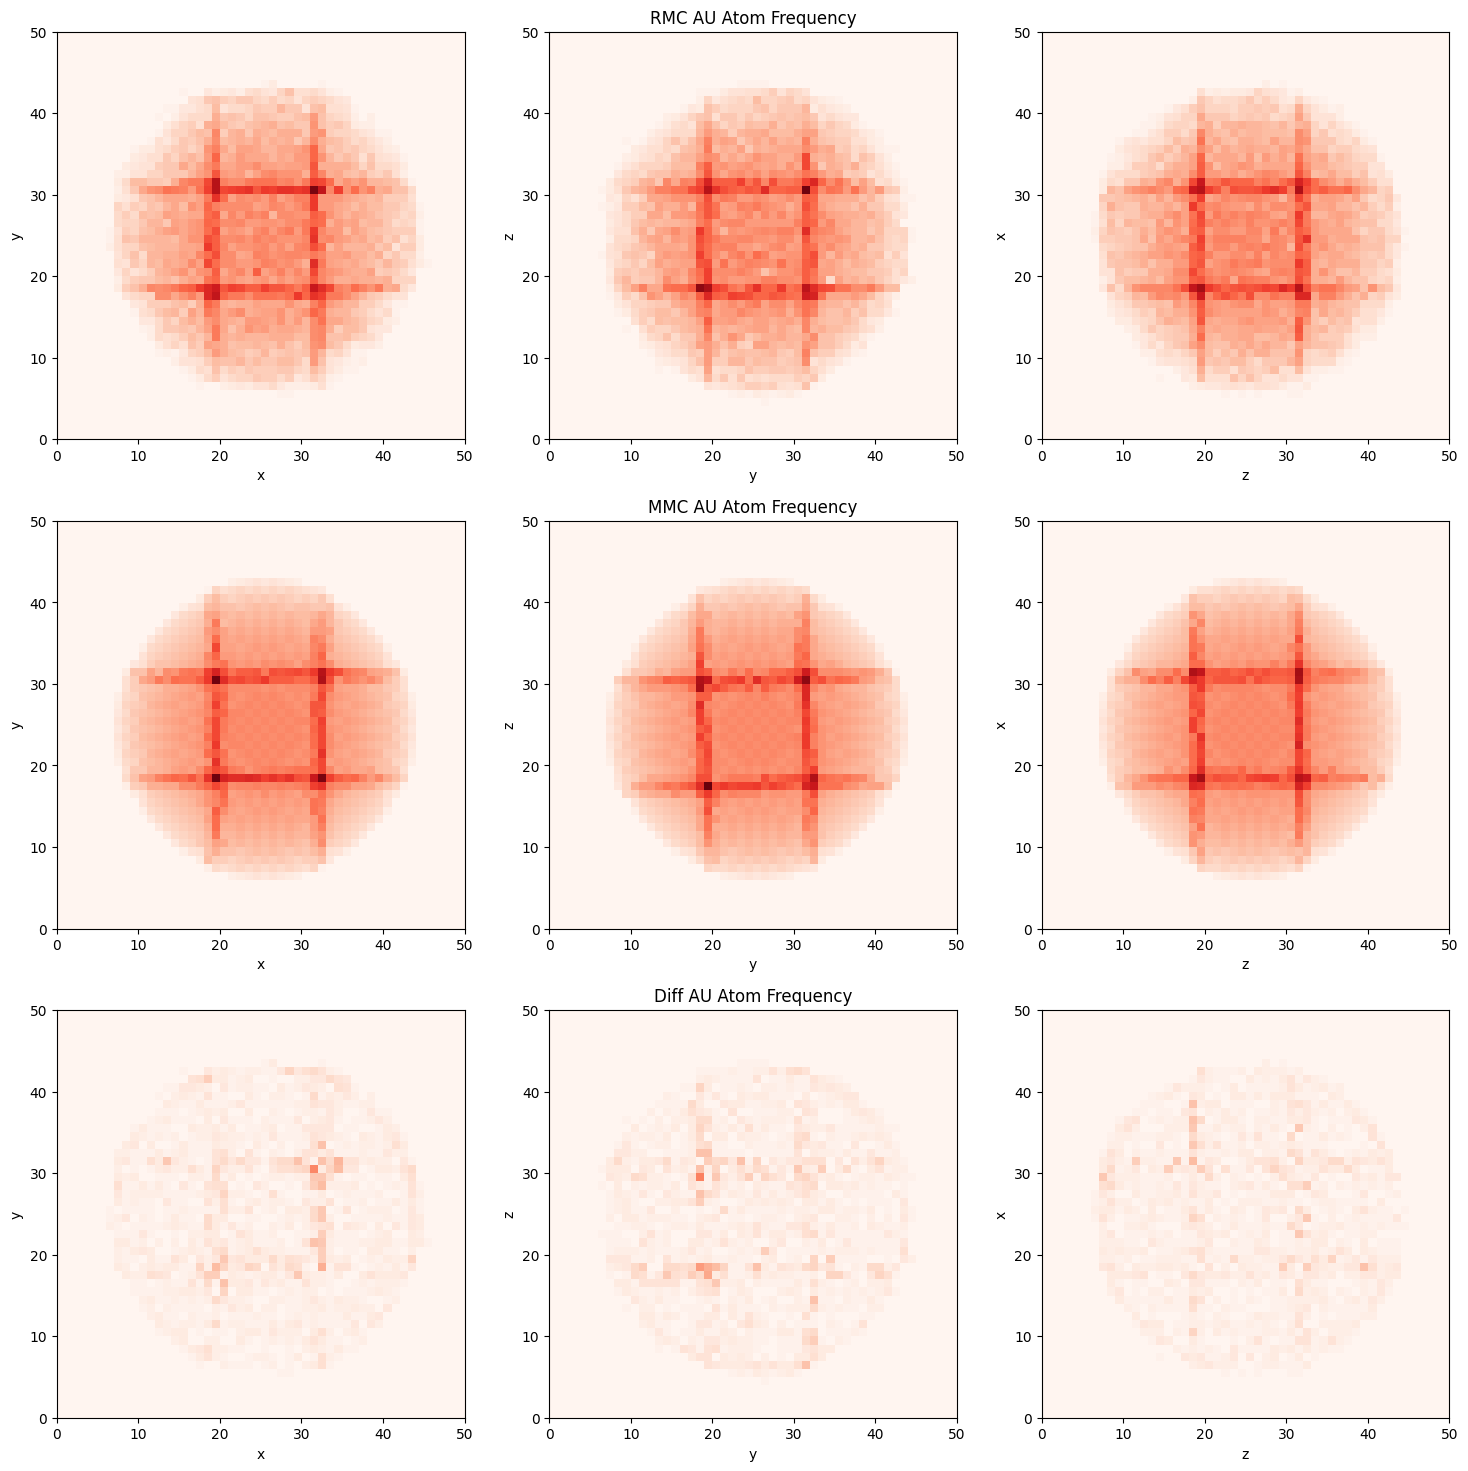

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[0,1].set_title("RMC "+atom+" Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[1,1].set_title("MMC "+atom+" Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[2,1].set_title("Diff "+atom+" Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

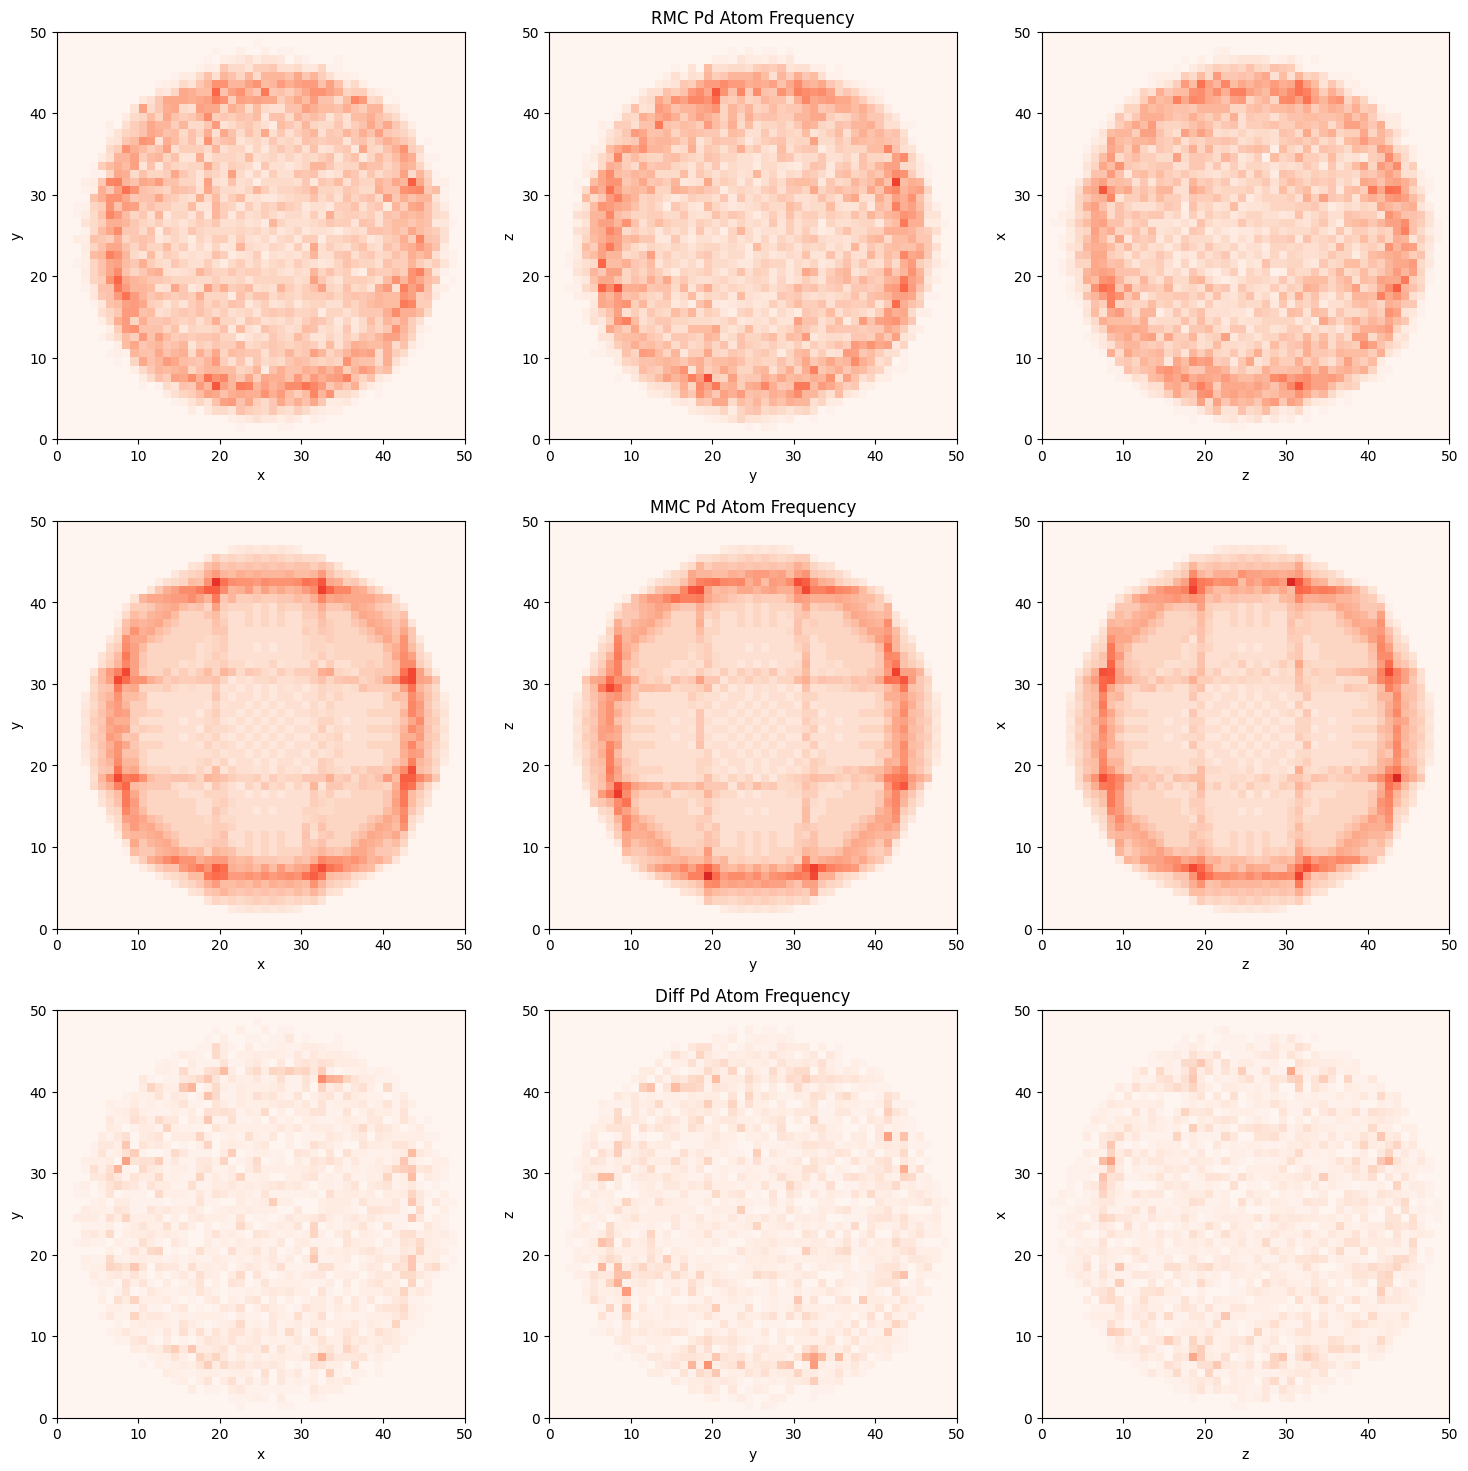

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[0,1].set_title("RMC Pd Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[1,1].set_title("MMC Pd Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_other_xy, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
axs[2,1].set_title("Diff Pd Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_other_yz, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_other_zx, interpolation='none', extent = (0,numbin,0,numbin), vmin=vmin, vmax=vmax, cmap = "Reds")

### Convert Binned Data into 2D arrays (With Slice through sphere)

In [ ]:
MMC_atom_xy = np.zeros((numbin,numbin))
MMC_other_xy = np.zeros((numbin,numbin))
RMC_atom_xy = np.zeros((numbin,numbin))
RMC_other_xy = np.zeros((numbin,numbin))
MMC_atom_yz = np.zeros((numbin,numbin))
MMC_other_yz = np.zeros((numbin,numbin))
RMC_atom_yz = np.zeros((numbin,numbin))
RMC_other_yz = np.zeros((numbin,numbin))
MMC_atom_zx = np.zeros((numbin,numbin))
MMC_other_zx = np.zeros((numbin,numbin))
RMC_atom_zx = np.zeros((numbin,numbin))
RMC_other_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_atom_xy[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["xbin"]==i) & (MMC_data_atom["ybin"]==j) & (MMC_data_atom["zbin"]<1) & (MMC_data_atom["zbin"]>-1)])
      MMC_other_xy[x][y] = len(MMC_data_other.loc[(MMC_data_other["xbin"]==i) & (MMC_data_other["ybin"]==j) & (MMC_data_other["zbin"]<1) & (MMC_data_other["zbin"]>-1)])
      RMC_atom_xy[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["xbin"]==i) & (RMC_data_atom["ybin"]==j) & (MMC_data_atom["zbin"]<1) & (MMC_data_atom["zbin"]>-1)])
      RMC_other_xy[x][y] = len(RMC_data_other.loc[(RMC_data_other["xbin"]==i) & (RMC_data_other["ybin"]==j) & (MMC_data_other["zbin"]<1) & (MMC_data_other["zbin"]>-1)])

      MMC_atom_yz[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["ybin"]==i) & (MMC_data_atom["zbin"]==j) & (MMC_data_atom["xbin"]<1) & (MMC_data_atom["xbin"]>-1)])
      MMC_other_yz[x][y] = len(MMC_data_other.loc[(MMC_data_other["ybin"]==i) & (MMC_data_other["zbin"]==j) & (MMC_data_other["xbin"]<1) & (MMC_data_other["xbin"]>-1)])
      RMC_atom_yz[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["ybin"]==i) & (RMC_data_atom["zbin"]==j) & (MMC_data_atom["xbin"]<1) & (MMC_data_atom["xbin"]>-1)])
      RMC_other_yz[x][y] = len(RMC_data_other.loc[(RMC_data_other["ybin"]==i) & (RMC_data_other["zbin"]==j) & (MMC_data_other["xbin"]<1) & (MMC_data_other["xbin"]>-1)])

      MMC_atom_zx[x][y] = len(MMC_data_atom.loc[(MMC_data_atom["zbin"]==i) & (MMC_data_atom["xbin"]==j) & (MMC_data_atom["ybin"]<1) & (MMC_data_atom["ybin"]>-1)])
      MMC_other_zx[x][y] = len(MMC_data_other.loc[(MMC_data_other["zbin"]==i) & (MMC_data_other["xbin"]==j) & (MMC_data_other["ybin"]<1) & (MMC_data_other["ybin"]>-1)])
      RMC_atom_zx[x][y] = len(RMC_data_atom.loc[(RMC_data_atom["zbin"]==i) & (RMC_data_atom["xbin"]==j) & (MMC_data_atom["ybin"]<1) & (MMC_data_atom["ybin"]>-1)])
      RMC_other_zx[x][y] = len(RMC_data_other.loc[(RMC_data_other["zbin"]==i) & (RMC_data_other["xbin"]==j) & (MMC_data_other["ybin"]<1) & (MMC_data_other["ybin"]>-1)])
    except:
      None
    y+=1
  x+=1

In [ ]:
diff_atom_xy = np.absolute(np.array(MMC_atom_xy) - np.array(RMC_atom_xy))
diff_atom_yz = np.absolute(np.array(MMC_atom_yz) - np.array(RMC_atom_yz))
diff_atom_zx = np.absolute(np.array(MMC_atom_zx) - np.array(RMC_atom_zx))

diff_other_xy = np.absolute(np.array(MMC_other_xy) - np.array(RMC_other_xy))
diff_other_yz = np.absolute(np.array(MMC_other_yz) - np.array(RMC_other_yz))
diff_other_zx = np.absolute(np.array(MMC_other_zx) - np.array(RMC_other_zx))

In [ ]:
vmin = 0
vmax = np.array([MMC_atom_xy.max(), MMC_other_xy.max(), RMC_atom_xy.max(), RMC_other_xy.max(),
                 MMC_atom_yz.max(),MMC_other_yz.max(), RMC_atom_yz.max(), RMC_other_yz.max(),
                 MMC_atom_zx.max(), MMC_other_zx.max(), RMC_atom_zx.max(), RMC_other_zx.max()]).max()
print(vmax)

8.0


### Plot Binned Data (Frequency Plots)

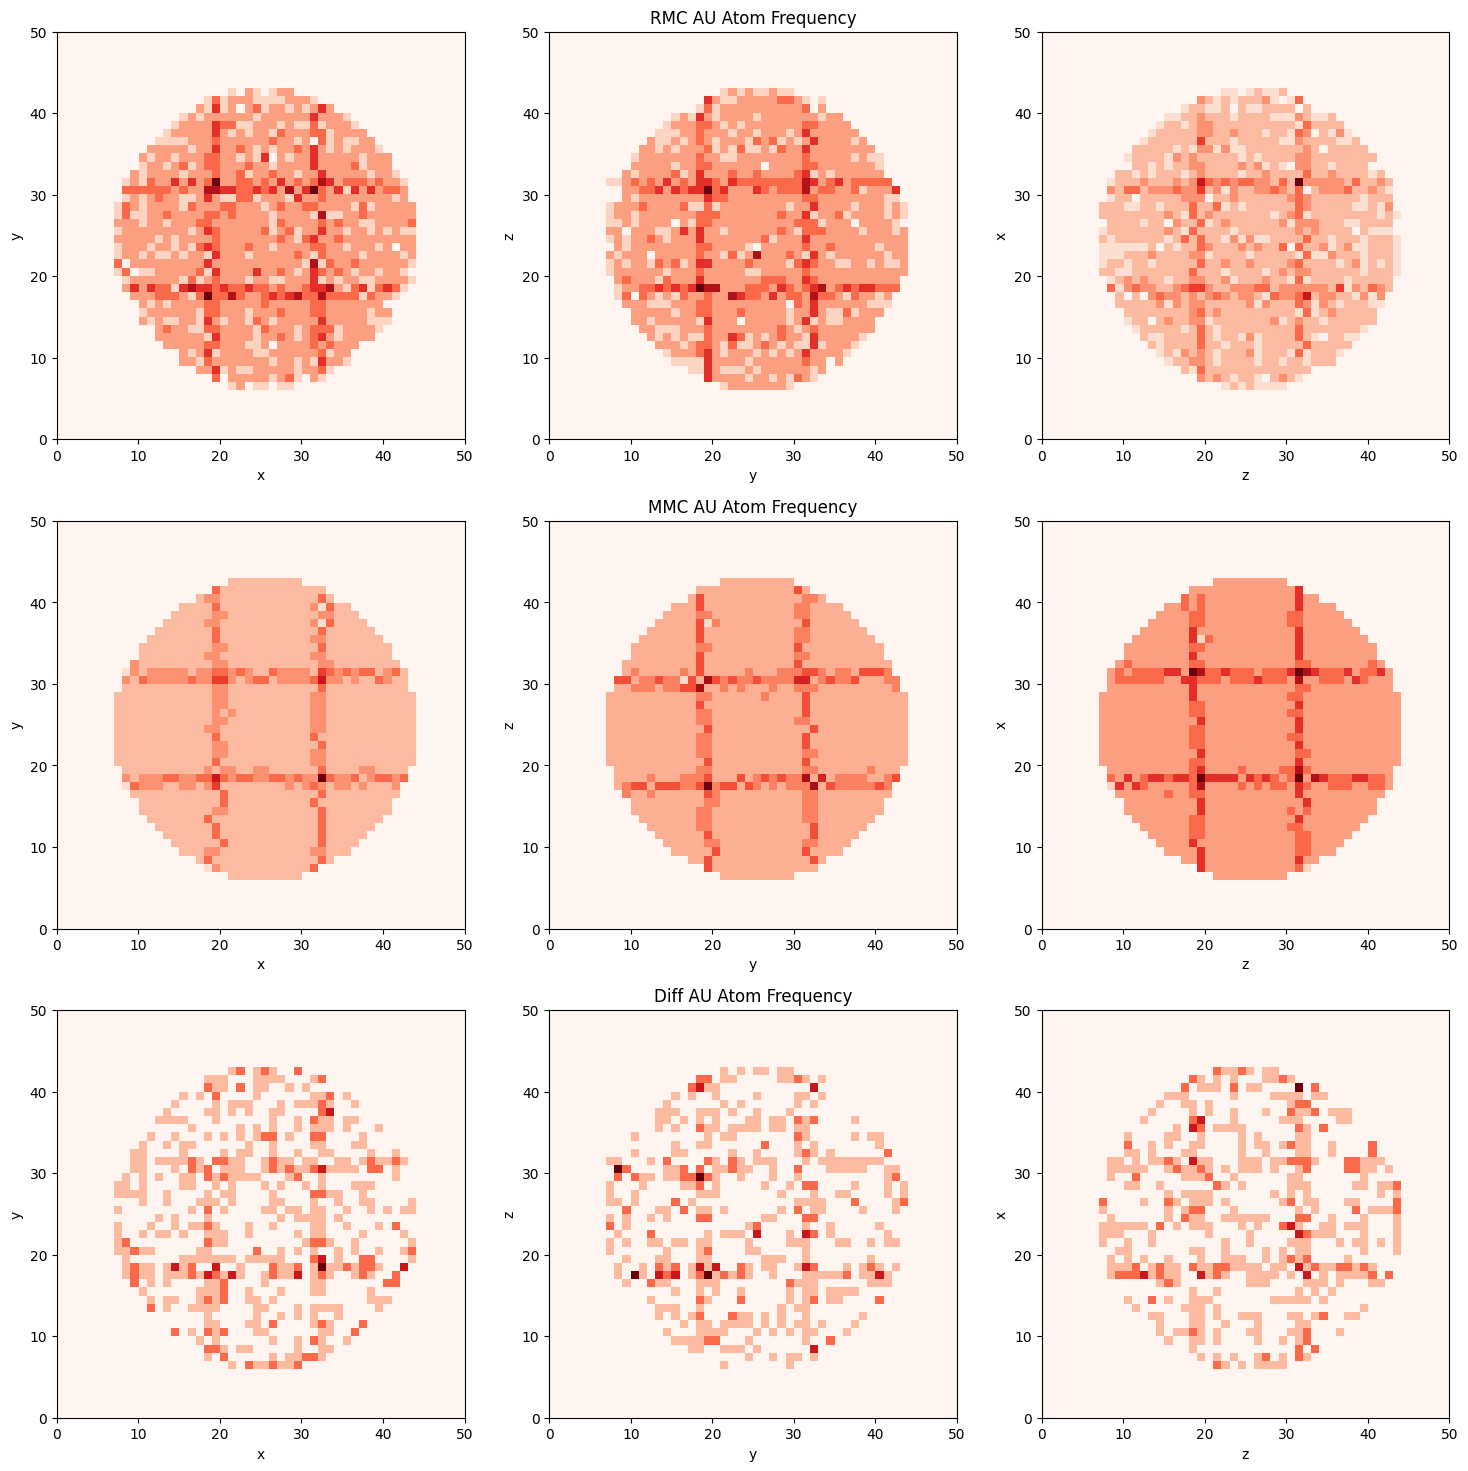

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[0,1].set_title("RMC "+atom+" Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[1,1].set_title("MMC "+atom+" Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_atom_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[2,1].set_title("Diff "+atom+" Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_atom_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_atom_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

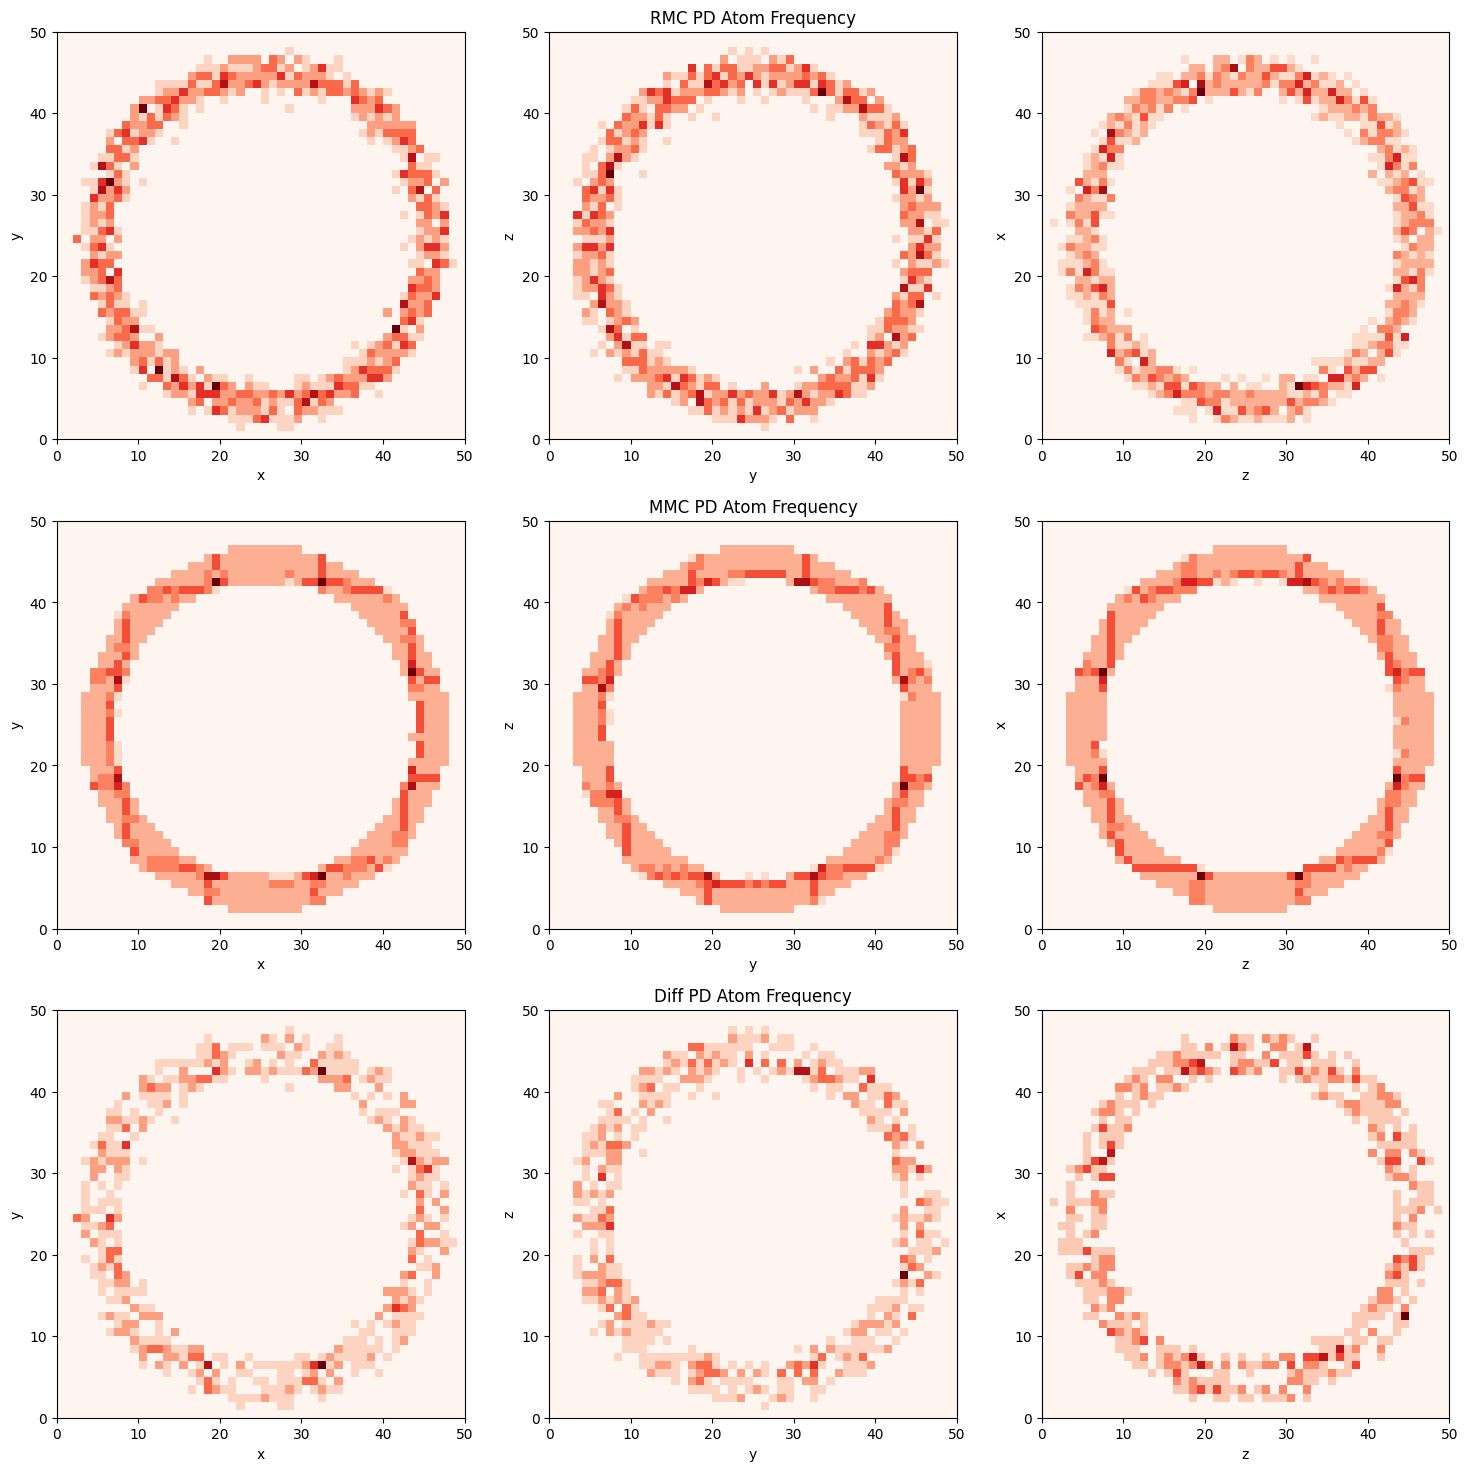

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(18, 6), ncols=3, nrows=2)
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[0,1].set_title("RMC "+other_atom+" Atom Frequency")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_other_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[1,1].set_title("MMC "+other_atom+" Atom Frequency")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_other_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_other_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_other_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
axs[2,1].set_title("Diff "+other_atom+" Atom Frequency")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_other_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_other_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "Reds")

## 2D Composition Plot

Indicates the composition of the reconstructed sphere through the volume that each 2D bin corresponds to

### Convert Binned Data ino 2D Arrays

In [ ]:
###############################################################################
# Format's Data into arrays that contain the Au fraction in the appropriate
# channel/bin then normalizes about 0. (i.e. -.5 means all Pd whereas +.5 means all Au)
###############################################################################
MMC_xy = np.zeros((numbin,numbin))
RMC_xy = np.zeros((numbin,numbin))
MMC_yz = np.zeros((numbin,numbin))
RMC_yz = np.zeros((numbin,numbin))
MMC_zx = np.zeros((numbin,numbin))
RMC_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_xy[x][y] = len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["atom"]==atom)]) / len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j)])-0.5
      RMC_xy[x][y] = len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["atom"]==atom)]) / len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j)])-0.5

      MMC_yz[x][y] = len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["atom"]==atom)]) / len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j)])-0.5
      RMC_yz[x][y] = len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["atom"]==atom)]) / len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j)])-0.5

      MMC_zx[x][y] = len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["atom"]==atom)]) / len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j)])-0.5
      RMC_zx[x][y] = len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["atom"]==atom)]) / len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j)])-0.5
    except:
      None
    y+=1
  x+=1
###############################################################################
# Finds the difference between the RMC and MMC Au fractions
###############################################################################
diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

### Plot Binned Data

<ipython-input-61-3b42c9bda63b>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


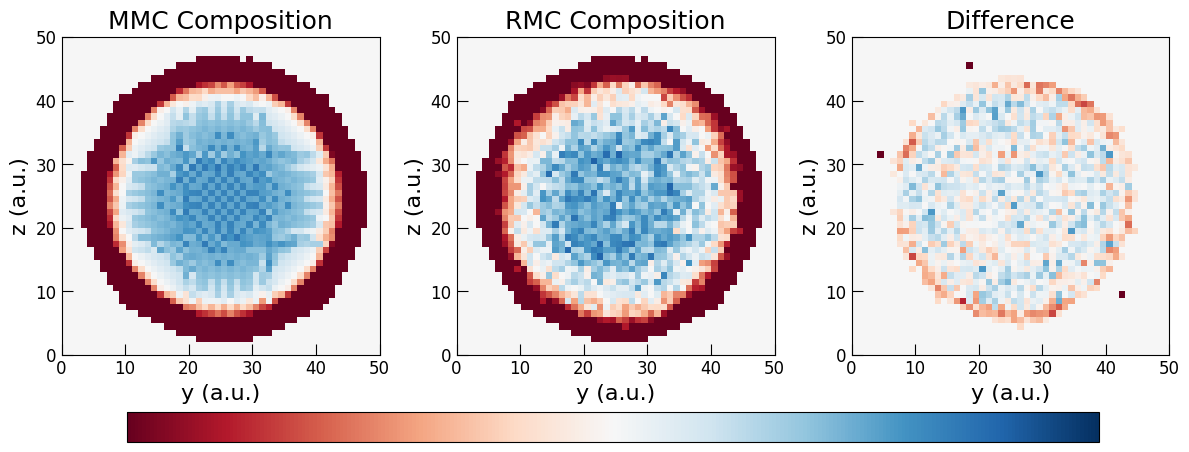

In [ ]:
fig, axs = plt.subplots(1, 3,figsize=(12, 6))
axs[0].set_title("MMC Composition", fontsize=18)
axs[0].set_xlabel("y (a.u.)", fontsize=16)
axs[0].set_ylabel("z (a.u.)", fontsize=16)
axs[0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0].tick_params(axis='x', labelsize=12, direction='in', length=8)
im = axs[0].imshow(MMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-.5,.5))

axs[1].set_title("RMC Composition", fontsize=18)
axs[1].set_xlabel("y (a.u.)", fontsize=16)
axs[1].set_ylabel("z (a.u.)", fontsize=16)
axs[1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1].imshow(RMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-.5,.5))

axs[2].set_title("Difference", fontsize=18)
axs[2].set_xlabel("y (a.u.)", fontsize=16)
axs[2].set_ylabel("z (a.u.)", fontsize=16)
axs[2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2].imshow(diff_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-.5,.5))

cax = plt.axes((0.11, 0.09, .81, 0.05))
fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[])

plt.tight_layout()

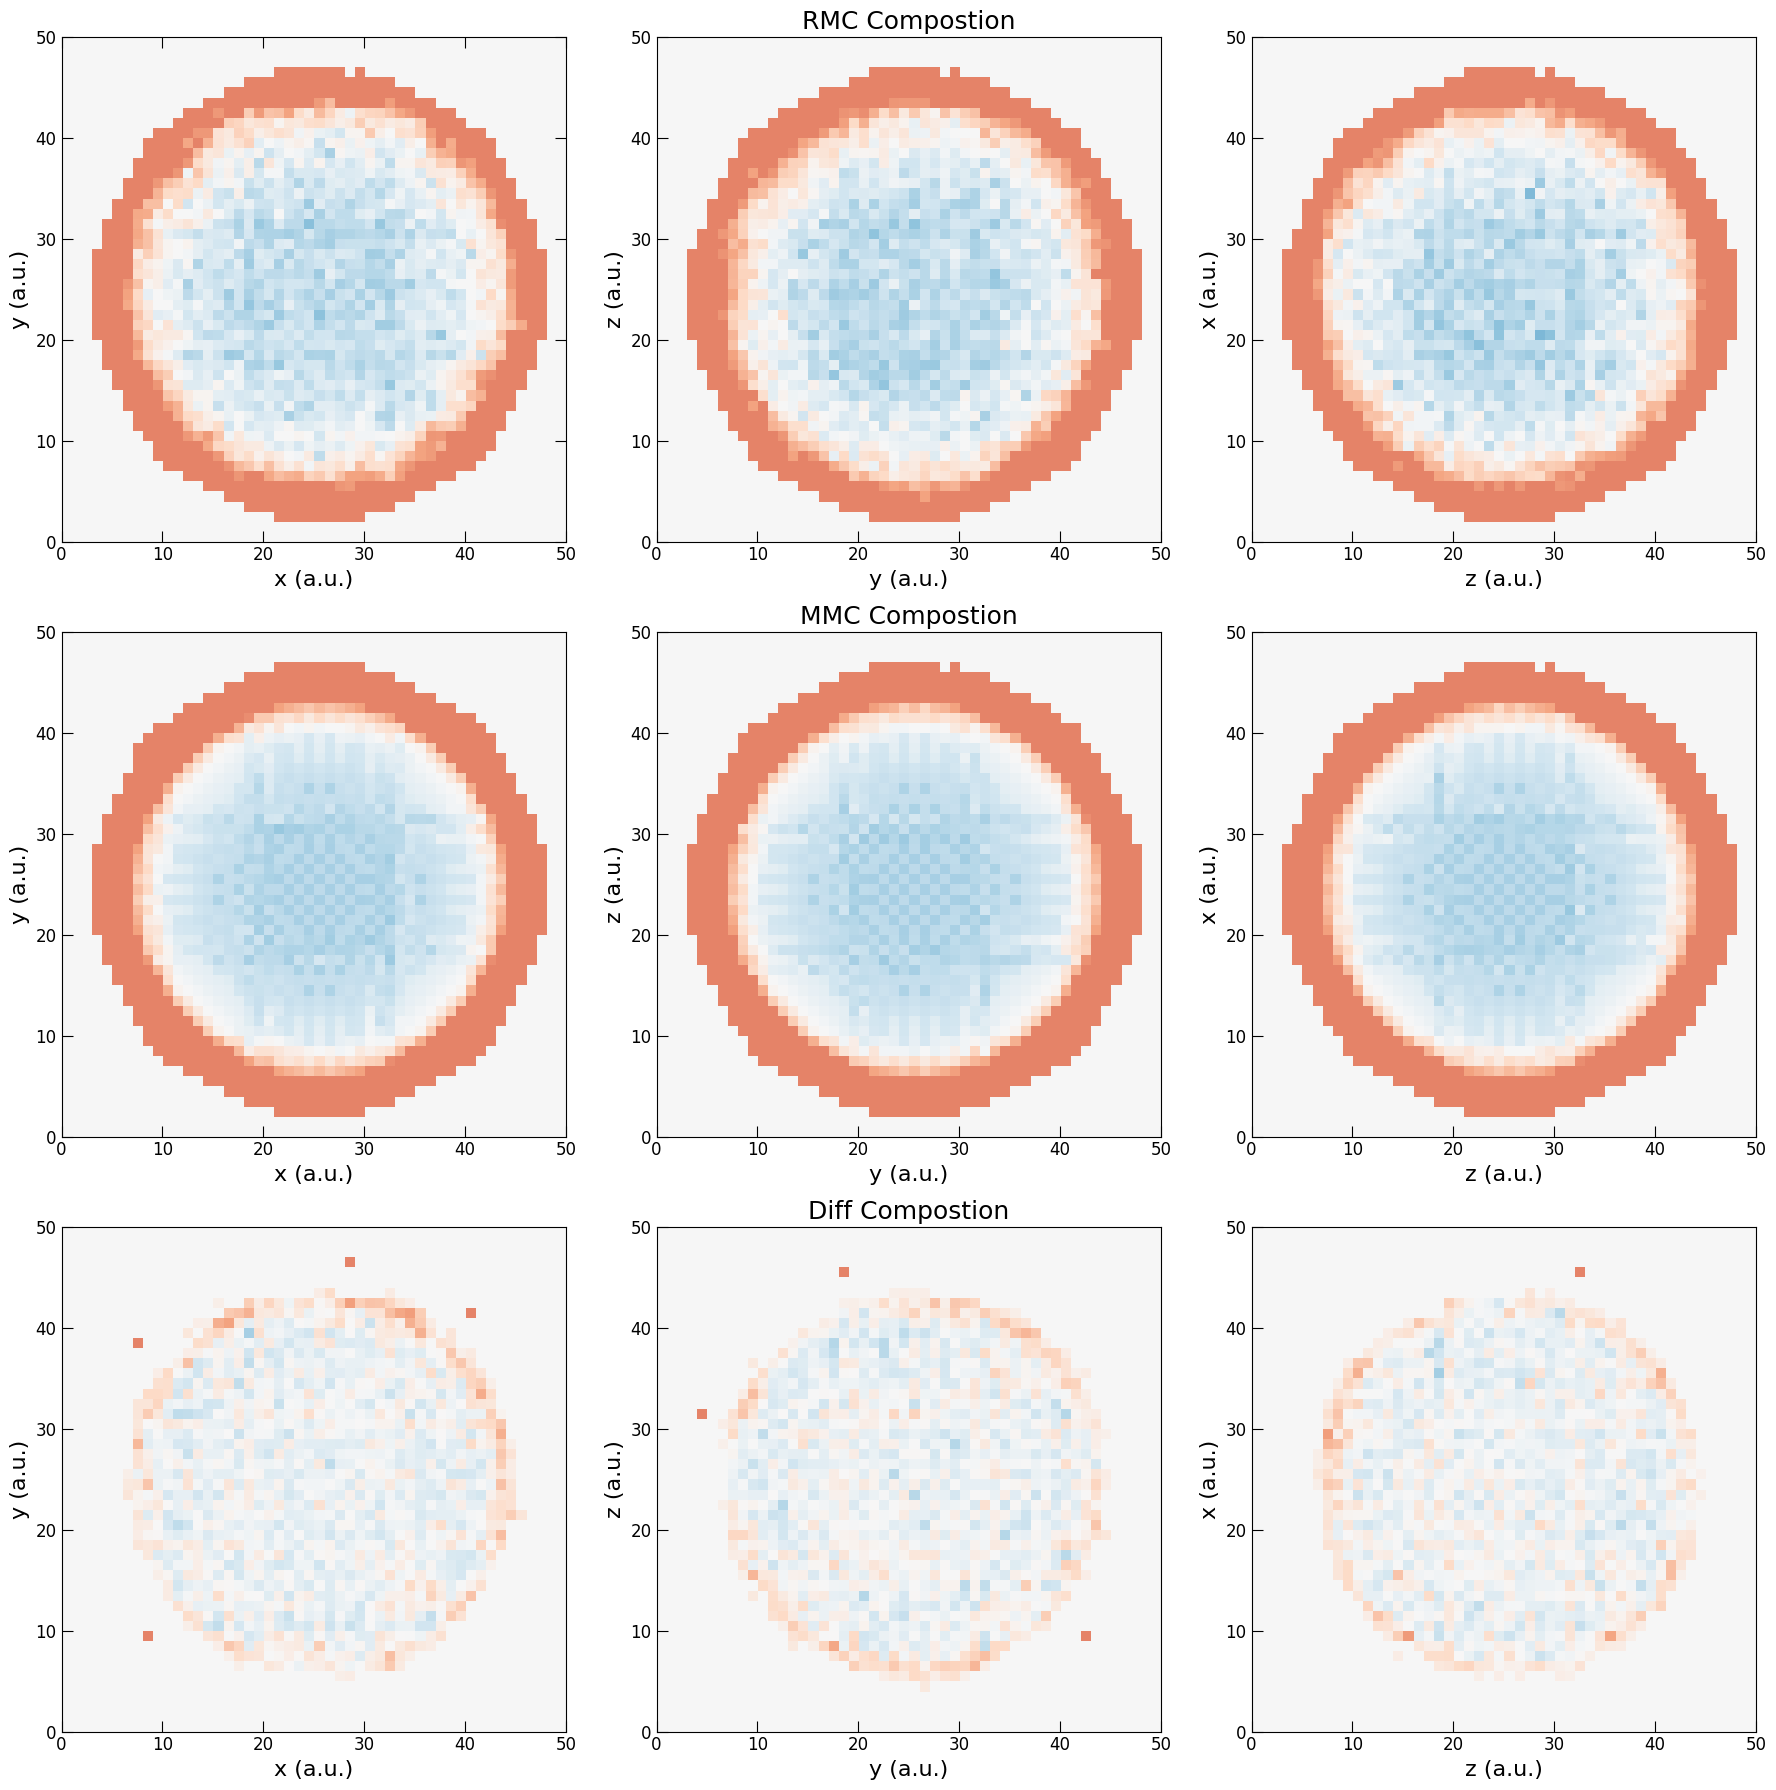

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
###
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x (a.u.)", fontsize=16)
axs[0,0].set_ylabel("y (a.u.)", fontsize=16)
axs[0,0].tick_params(bottom=True, top=True, left=True, right=True)
axs[0,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,0].imshow(RMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[0,1].set_title("RMC Compostion", fontsize=18)
axs[0,1].set_xlabel("y (a.u.)", fontsize=16)
axs[0,1].set_ylabel("z (a.u.)", fontsize=16)
axs[0,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,1].imshow(RMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z (a.u.)", fontsize=16)
axs[0,2].set_ylabel("x (a.u.)", fontsize=16)
axs[0,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,2].imshow(RMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

###
#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x (a.u.)", fontsize=16)
axs[1,0].set_ylabel("y (a.u.)", fontsize=16)
axs[1,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,0].imshow(MMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[1,1].set_title("MMC Compostion", fontsize=18)
axs[1,1].set_xlabel("y (a.u.)", fontsize=16)
axs[1,1].set_ylabel("z (a.u.)", fontsize=16)
axs[1,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,1].imshow(MMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z (a.u.)", fontsize=16)
axs[1,2].set_ylabel("x (a.u.)", fontsize=16)
axs[1,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,2].imshow(MMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

###
#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x (a.u.)", fontsize=16)
axs[2,0].set_ylabel("y (a.u.)", fontsize=16)
axs[2,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,0].imshow(diff_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
axs[2,1].set_title("Diff Compostion", fontsize=18)
axs[2,1].set_xlabel("y (a.u.)", fontsize=16)
axs[2,1].set_ylabel("z (a.u.)", fontsize=16)
axs[2,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,1].imshow(diff_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
###
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z (a.u.)", fontsize=16)
axs[2,2].set_ylabel("x (a.u.)", fontsize=16)
axs[2,2].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[2,2].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[2,2].imshow(diff_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
plt.tight_layout()

## 2D Composition Plot of Slice

### Convert Binned Data into 2D Arrays

In [ ]:
###############################################################################
# Format's Data into arrays that contain the Au fraction in the appropriate
# channel/bin then normalizes about 0. (i.e. -.5 means all Pd whereas +.5 means all Au)
###############################################################################
MMC_xy = np.zeros((numbin,numbin))
RMC_xy = np.zeros((numbin,numbin))
MMC_yz = np.zeros((numbin,numbin))
RMC_yz = np.zeros((numbin,numbin))
MMC_zx = np.zeros((numbin,numbin))
RMC_zx = np.zeros((numbin,numbin))
x = 0
for i in realBins:
  y=0
  for j in realBins:
    try:
      MMC_xy[x][y] = len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["atom"]==atom) & (MMC_data["zbin"]<1) & (MMC_data["zbin"]>-1)]) / len(MMC_data.loc[(MMC_data["xbin"]==i) & (MMC_data["ybin"]==j) & (MMC_data["zbin"]<1) & (MMC_data["zbin"]>-1)])-0.5
      RMC_xy[x][y] = len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["atom"]==atom) & (RMC_data["zbin"]<1) & (RMC_data["zbin"]>-1)]) / len(RMC_data.loc[(RMC_data["xbin"]==i) & (RMC_data["ybin"]==j) & (RMC_data["zbin"]<1) & (RMC_data["zbin"]>-1)])-0.5

      MMC_yz[x][y] = len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["atom"]==atom) & (MMC_data["xbin"]<1) & (MMC_data["xbin"]>-1)]) / len(MMC_data.loc[(MMC_data["ybin"]==i) & (MMC_data["zbin"]==j) & (MMC_data["xbin"]<1) & (MMC_data["xbin"]>-1)])-0.5
      RMC_yz[x][y] = len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["atom"]==atom) & (RMC_data["xbin"]<1) & (RMC_data["xbin"]>-1)]) / len(RMC_data.loc[(RMC_data["ybin"]==i) & (RMC_data["zbin"]==j) & (RMC_data["xbin"]<1) & (RMC_data["xbin"]>-1)])-0.5

      MMC_zx[x][y] = len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["atom"]==atom) & (MMC_data["ybin"]<1) & (MMC_data["ybin"]>-1)]) / len(MMC_data.loc[(MMC_data["zbin"]==i) & (MMC_data["xbin"]==j) & (MMC_data["ybin"]<1) & (MMC_data["ybin"]>-1)])-0.5
      RMC_zx[x][y] = len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["atom"]==atom) & (RMC_data["ybin"]<1) & (RMC_data["ybin"]>-1)]) / len(RMC_data.loc[(RMC_data["zbin"]==i) & (RMC_data["xbin"]==j) & (RMC_data["ybin"]<1) & (RMC_data["ybin"]>-1)])-0.5
    except:
      None
    y+=1
  x+=1
###############################################################################
# Finds the difference between the RMC and MMC Au fractions
###############################################################################
diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

diff_xy = (np.array(MMC_xy) - np.array(RMC_xy))
diff_yz = (np.array(MMC_yz) - np.array(RMC_yz))
diff_zx =(np.array(MMC_zx) - np.array(RMC_zx))

### Plot Binned Data

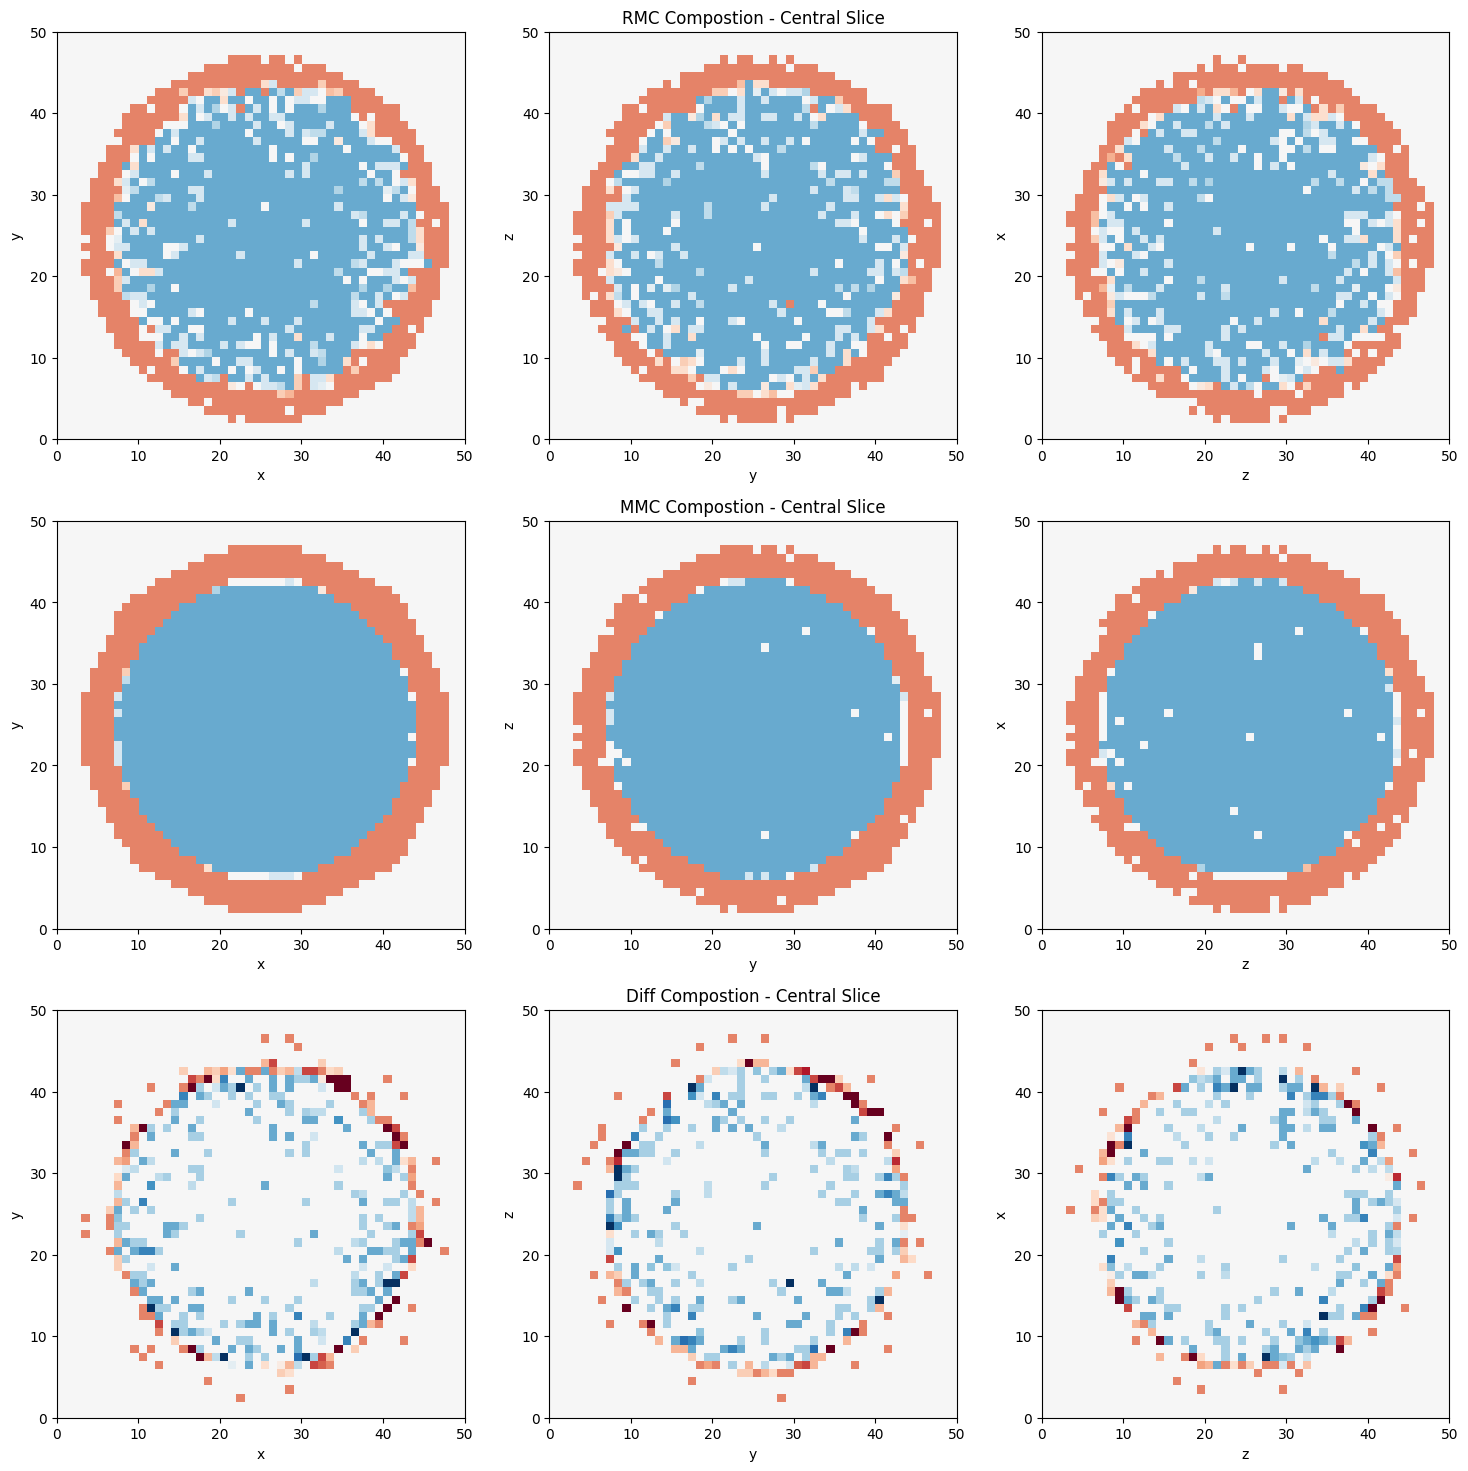

In [ ]:
###############################################################################
fig, axs = plt.subplots(3, 3,figsize=(18, 18))
#ax1.set_title("RMC Au Atom Frequency")
axs[0,0].set_xlabel("x")
axs[0,0].set_ylabel("y")
axs[0,0].imshow(RMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[0,1].set_title("RMC Compostion - Central Slice")
axs[0,1].set_xlabel("y")
axs[0,1].set_ylabel("z")
axs[0,1].imshow(RMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("RMC Au Atom Frequency")
axs[0,2].set_xlabel("z")
axs[0,2].set_ylabel("x")
axs[0,2].imshow(RMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[1,0].set_xlabel("x")
axs[1,0].set_ylabel("y")
axs[1,0].imshow(MMC_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[1,1].set_title("MMC Compostion - Central Slice")
axs[1,1].set_xlabel("y")
axs[1,1].set_ylabel("z")
axs[1,1].imshow(MMC_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("MMC Au Atom Frequency")
axs[1,2].set_xlabel("z")
axs[1,2].set_ylabel("x")
axs[1,2].imshow(MMC_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))

#axs[1,0].set_title("MMC Au Atom Frequency")
axs[2,0].set_xlabel("x")
axs[2,0].set_ylabel("y")
axs[2,0].imshow(diff_xy, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
axs[2,1].set_title("Diff Compostion - Central Slice")
axs[2,1].set_xlabel("y")
axs[2,1].set_ylabel("z")
axs[2,1].imshow(diff_yz, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))
#ax3.set_title("MMC Au Atom Frequency")
axs[2,2].set_xlabel("z")
axs[2,2].set_ylabel("x")
axs[2,2].imshow(diff_zx, interpolation='none', extent = (0,numbin,0,numbin), cmap = "RdBu", clim=(-1,1))